In [ ]:
from brian2 import *
import numpy as np

defaultclock.dt = 0.01*ms

m = 10**-3


# excitatory neurons
tau_ref = 1.5*ms; tau_m = 15*ms
El = -60*mV; Vt = -50*mV; Dt_e = 2*mV; Vre = -65*mV; Vth = -10*mV

# inhibitory neurons
tau_m_i = 10*ms; Dt_i = 0.5*mV; tau_ref_i = 0.5*ms

# synapses

rows_p, cols_p = 50, 50
rows_e, cols_e = 200, 200
rows_i, cols_i = 100, 100

# synapse equations
tau_re = 1*ms; tau_de = 5*ms;
tau_ri = 1*ms; tau_di = 8*ms;

# equations for excitatory neurons
eqns_e = '''
dV_e/dt = (-(V_e-El) + Dt_e*exp((V_e-Vt)/Dt_e) + I_e + I_ie)/tau_m : volt

dI_e/dt = (-I_e + a_e)/tau_de : volt
da_e/dt = -a_e/tau_re : volt

dI_ie/dt = (-I_ie + a_ie)/tau_di : volt
da_ie/dt = -a_ie/tau_ri : volt

x_e : meter
y_e : meter
'''

# equations for inhibitory neurons
eqns_i = '''
dV_i/dt = (-(V_i-El) + Dt_i*exp((V_i-Vt)/Dt_i) + I_i + I_fi)/tau_m_i : volt

dI_i/dt = (-I_i + a_i)/tau_di : volt
da_i/dt = -a_i/tau_ri : volt

dI_fi/dt = (-I_fi + a_fi)/tau_de : volt
da_fi/dt = -a_fi/tau_re : volt

x_i : meter
y_i : meter
'''

# layer 1 poisson neurons
eqns_p = '''
rate : Hz
x_p : meter 
y_p : meter
'''

G_e = NeuronGroup(rows_e * cols_e, eqns_e, threshold='V_e>Vth', reset='V_e=-65*mV', refractory=tau_ref, method='euler')
# initialize the grid positions
G_e.x_e = '((i // rows_e)/(rows_e-1))*meter' ; G_e.y_e = '((i % cols_e)/(cols_e-1))*meter'
G_e.V_e = np.random.random(rows_e*cols_e) * -10*mV


G_i = NeuronGroup(rows_i * cols_i, eqns_i, threshold='V_i>Vth', reset='V_i=-65*mV', refractory=tau_ref_i, method='euler')
# initialize the grid positions
G_i.x_i = '((i // rows_i)/(rows_i-1))*meter' ; G_i.y_i = '((i % cols_i)/(cols_i-1))*meter'
G_i.V_i = np.random.random(rows_i*cols_i) * -10*mV

P = NeuronGroup(rows_p * cols_p, eqns_p, threshold='rand() < rate*dt', method='euler')
P.rate = 10*Hz
P.x_p = '((i // rows_p)/(rows_p-1))*meter' ; P.y_p = '((i % cols_p)/(cols_p-1))*meter'


## Layer 1 to Layer 2 feedforward connections

# Fe connections

S_fe = Synapses(P, G_e, 'w:volt', on_pre='a_e+=w')
S_fe.connect(p = '0.1 * exp(-((x_p_pre-x_e_post)**2 + (y_p_pre-y_e_post)**2)/(2*(0.05)**2))')
S_fe.w = 0.63*mvolt

# Fi connections

S_fi = Synapses(P, G_i, 'w:volt', on_pre='a_fi+=w')
S_fi.connect(p = '0.05 * exp(-((x_p_pre-x_i_post)**2 + (y_p_pre-y_i_post)**2)/(2*(0.05)**2))')
S_fi.w = 0.45*mvolt


## Layer 2 connections

# ee connections
S_ee = Synapses(G_e, G_e, 'w:volt', on_pre='a_e+=w')
S_ee.connect('i != j', p = '0.01 * exp(-((x_e_pre-x_e_post)**2 + (y_e_pre-y_e_post)**2)/(2*(0.1)**2))')
S_ee.w = 0.36*mvolt

# ii connections

S_ii = Synapses(G_i, G_i, 'w:volt', on_pre='a_i+=w')
S_ii.connect('i != j', p = '0.04 * exp(-((x_i_pre-x_i_post)**2 + (y_i_pre-y_i_post)**2)/(2*(0.1)**2))')
S_ii.w = -1.34*mvolt

# ei connections

S_ei = Synapses(G_e, G_i, 'w:volt', on_pre='a_i+=w')
S_ei.connect(p = '0.03 * exp(-((x_e_pre-x_i_post)**2 + (y_e_pre-y_i_post)**2)/(2*(0.1)**2))')
S_ei.w = 0.19*mvolt

# ie connections

S_ie = Synapses(G_i, G_e, 'w:volt', on_pre='a_ie+=w')
S_ie.connect(p = '0.04 * exp(-((x_i_pre-x_e_post)**2 + (y_i_pre-y_e_post)**2)/(2*(0.1)**2))')
S_ie.w = -1.07*mvolt


M_Ge = SpikeMonitor(G_e,variables=['V_e','x_e','y_e'])
Ms_Ge = StateMonitor(G_e,variables=['V_e','a_e','I_e'], record=[0, 1, 2, 3, 4, 5])

M_Gi = SpikeMonitor(G_i,variables=['V_i','x_i','y_i'])


run(5*second)


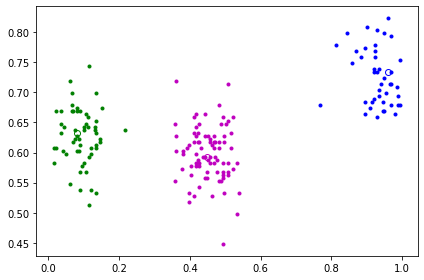

In [2]:
# Feedforward f-e connections

# Show the connections for some neurons in different colors
for color in ['g', 'b', 'm']:
    
    neuron_idx = np.random.randint(0, rows_p*cols_p)
    plot(P.x_p[neuron_idx] / meter, P.y_p[neuron_idx] / meter, 'o', mec=color,
         mfc='none')
    plot(G_e.x_e[S_fe.j[neuron_idx, :]] / meter,
         G_e.y_e[S_fe.j[neuron_idx, :]] / meter, color + '.')

#for idx, t in enumerate(['random connections']):
    '''
    xlim( 0, rows_e )
    ylim(0, cols_e)
    title(t)
    xlabel('x')
    ylabel('y', rotation='horizontal')
    axis('equal')
    '''

tight_layout()
show()

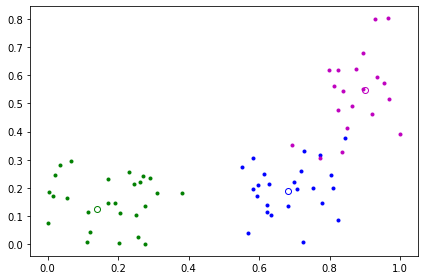

In [3]:
# Recurrent e-e connections

# Show the connections for some neurons in different colors
for color in ['g', 'b', 'm']:
    
    neuron_idx = np.random.randint(0, rows_e*cols_e)
    plot(G_e.x_e[neuron_idx] / meter, G_e.y_e[neuron_idx] / meter, 'o', mec=color,
         mfc='none')
    plot(G_e.x_e[S_ee.j[neuron_idx, :]] / meter,
         G_e.y_e[S_ee.j[neuron_idx, :]] / meter, color + '.')

#for idx, t in enumerate(['random connections']):
    '''
    xlim( 0, rows_e )
    ylim(0, cols_e)
    title(t)
    xlabel('x')
    ylabel('y', rotation='horizontal')
    axis('equal')
    '''

tight_layout()
show()

(0, 1000)

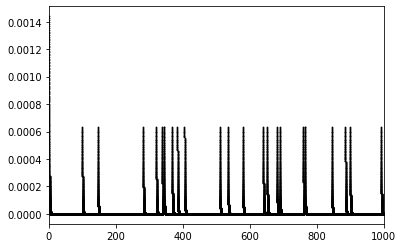

In [7]:
plot(Ms_Ge[4].t/ms, Ms_Ge[4].a_e.T, 'k.', ms=1.5)
xlim(0,1000)

(0, 1000)

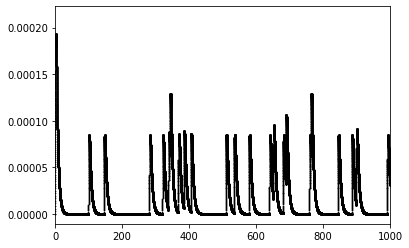

In [8]:
plot(Ms_Ge[4].t/ms, Ms_Ge[4].I_e.T, 'k.', ms=1.5)
xlim(0,1000)

Text(0, 0.5, 'Neuron index')

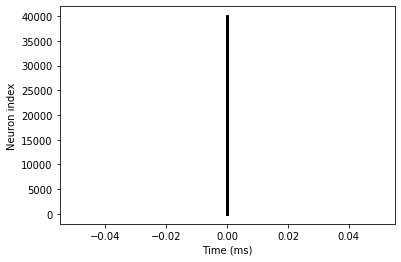

In [6]:
import matplotlib.pyplot as plt

i, t = M_Ge.it
plot(t/ms, i, 'k.', ms=1.5)

plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
